In [1]:
import sys
sys.path.append("models/vector")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch_geometric.transforms as transforms

from auxiliary.visualization import visualize_confusion_matrix
from auxiliary.misc import get_model_name

from initialize_vector import load_trained_vector_model
from dataset_vector import BuildingVectorDataset, get_dummy_sample
from metrics_vector import get_metrics_vector
from predict_vector import get_activations_vector
from thresholds_vector import vector_thresholds
from features import important_features

from models.pr_roc import get_pr_roc, plot_pr_curve, plot_roc_curve
from models.operators import elimination_operators, selection_operators, threshold_dic_to_tensor

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    vector_path = "../scratch/vector"
else:
    device = torch.device("cpu")
    # local path
    vector_path = "../data.nosync/vector"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

In [5]:
def load_validation_test_vector_dataset(operator_model, operators_to_predict, features, attach_roads, subset):
    '''Loads the validation and test dataset associated for the given model.'''
    # define path to validation and test data
    path_to_validation_data = os.path.join(vector_path, "training_data", operator_model, "validation")
    path_to_test_data = os.path.join(vector_path, "training_data", operator_model, "test")

    # construct validation Dataset (no transformations, no shuffling)
    validation_set = BuildingVectorDataset(path_to_validation_data, 
                                           operators=operators_to_predict, 
                                           features=features,
                                           attach_roads=attach_roads, 
                                           transform=None,
                                           subset=subset)
    
    # construct test Dataset (no transformations, no shuffling)
    test_set = BuildingVectorDataset(path_to_test_data, 
                                     operators=operators_to_predict, 
                                     features=features,
                                     attach_roads=attach_roads, 
                                     transform=None,
                                     subset=subset)

    return validation_set, test_set

## Elimination model

### Loading the trained model

In [6]:
# architecture: HGNN or HGT
architecture = "hgt"
# define whether roads should be attached
attach_roads = True

assert architecture in ("hgnn", "hgt")

# get the correct model name
if architecture == "hgnn":
    if attach_roads:
        model_filename = "HGNN_eli_attachRoadsTrue_481665p_100000s_80ep_bs512_cuda.pth"
    else:
        model_filename = "HGNN_eli_attachRoadsFalse_215937p_100000s_80ep_bs512_cuda.pth"
elif architecture == "hgt":
    if attach_roads:
        model_filename = "HGT_eli_attachRoadsTrue_700466p_100000s_70ep_bs512_cuda.pth"
    else:
        model_filename = "HGT_eli_attachRoadsFalse_452687p_100000s_70ep_bs512_cuda.pth"

# extracting model metadata
model_filename_split = model_filename.split("_")
n_training_samples = int(model_filename_split[-4][:-1])
n_epochs = int(model_filename_split[-3][:-2])
batch_size = int(model_filename_split[-2][2:])
device_trained_on = model_filename_split[-1][:-4]

# load the trained model
model = load_trained_vector_model(model_filename, vector_path, device)
print(model)

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 1 operators
Vector model successfully loaded.
HGT with 700,466 parameters


### Data loading

In [7]:
# define important features
features = important_features[f"{architecture.upper()} elimination"]

validation_set, test_set = load_validation_test_vector_dataset(operator_model="elimination", 
                                                               operators_to_predict=elimination_operators, 
                                                               features=features,
                                                               attach_roads=attach_roads, 
                                                               subset=None)

### ROC and PR curves

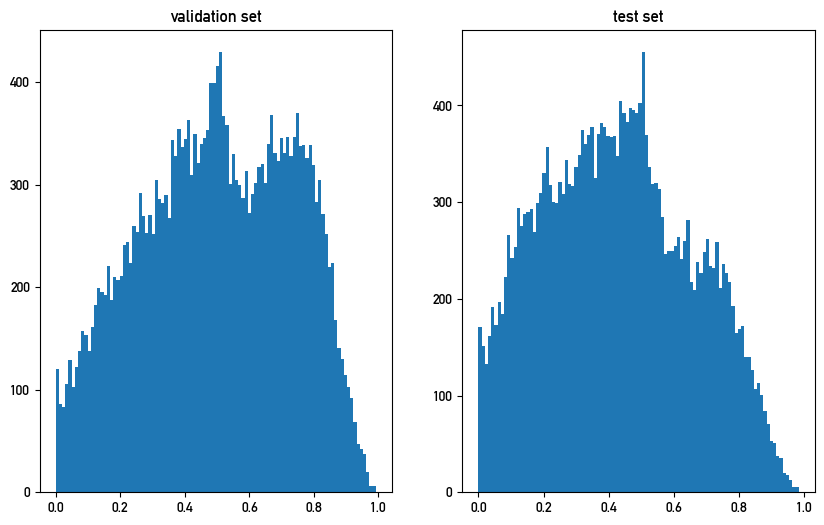

In [8]:
activations_validation = get_activations_vector(model, 
                                                dataset=validation_set, 
                                                batch_size=len(validation_set), 
                                                operators_to_pred=elimination_operators, 
                                                device=device)
activations_test = get_activations_vector(model, 
                                          dataset=test_set, 
                                          batch_size=len(test_set), 
                                          operators_to_pred=elimination_operators, 
                                          device=device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.hist(activations_validation, bins=100)
ax1.set_title("validation set")
ax2.hist(activations_test, bins=100)
ax2.set_title("test set")
plt.show()

In [9]:
dataset = "validation"

# get precision-recall and ROC values for different thresholds
pr_roc = get_pr_roc(model=model, 
                    dataset=validation_set, 
                    batch_size=len(validation_set), 
                    operators_to_pred=elimination_operators, 
                    device=device, 
                    interval=(0,1), 
                    increment=0.1)

# save the PR and ROC values
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=n_training_samples, 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device_trained_on) + f"_{dataset}.csv"
pr_roc_path = os.path.join(vector_path, "model_outputs", "elimination", "pr_roc", model_name)
pr_roc.to_csv(pr_roc_path, index=False)

In [10]:
dataset = "test"

# get precision-recall and ROC values for different thresholds
pr_roc = get_pr_roc(model=model, 
                    dataset=test_set, 
                    batch_size=len(test_set), 
                    operators_to_pred=elimination_operators, 
                    device=device, 
                    interval=(0,1), 
                    increment=0.1)

# save the PR and ROC values
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=n_training_samples, 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device_trained_on) + f"_{dataset}.csv"
pr_roc_path = os.path.join(vector_path, "model_outputs", "elimination", "pr_roc", model_name)
pr_roc.to_csv(pr_roc_path, index=False)

### Accuracy metrics

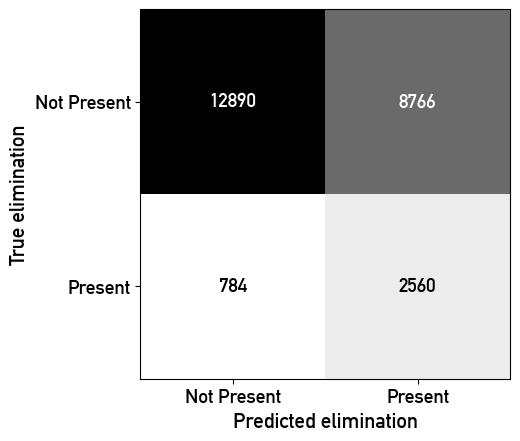

Accuracy: 0.618
Precision: 0.226
Recall: 0.766
F1 Score: 0.349


In [8]:
threshold = vector_thresholds[f"{architecture.upper()} elimination"]

# calculate accuracy metrics
metrics = get_metrics_vector(model=model, 
                             dataset=test_set,
                             batch_size=len(test_set),
                             operators_to_pred=elimination_operators, 
                             threshold=threshold, 
                             device=device)

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=n_training_samples, 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device_trained_on) + ".csv"
metrics_path = os.path.join(vector_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with accuracy metrics
metrics_df = pd.DataFrame({"operator": metrics["operator"],
                           "accuracy": metrics["accuracy"], 
                           "precision": metrics["precision"],
                           "recall": metrics["recall"],
                           "f1-score": metrics["f1_score"]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# print the results
for i in range(len(elimination_operators)):
    # display the confusion matrix
    visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])

    # print metrics
    print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
    print(f"Precision: {metrics['precision'][i]:.3f}")
    print(f"Recall: {metrics['recall'][i]:.3f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.3f}")

## Multi-operator model

### Loading the trained model

In [9]:
# architecture: HGNN or HGT
architecture = "hgt"
# define whether roads should be attached
attach_roads = True

assert architecture in ("hgnn", "hgt")

# get the correct model name
if architecture == "hgnn":
    if attach_roads:
        model_filename = "HGNN_sel_attachRoadsTrue_540548p_100000s_80ep_bs512_cuda.pth"
    else:
        model_filename = "HGNN_sel_attachRoadsFalse_271236p_100000s_80ep_bs512_cuda.pth"
elif architecture == "hgt":
    if attach_roads:
        model_filename = "HGT_sel_attachRoadsTrue_750389p_100000s_130ep_bs512_cuda.pth"
    else:
        model_filename = "HGT_sel_attachRoadsFalse_502610p_100000s_130ep_bs512_cuda.pth"

# extracting model metadata
model_filename_split = model_filename.split("_")
n_training_samples = int(model_filename_split[-4][:-1])
n_epochs = int(model_filename_split[-3][:-2])
batch_size = int(model_filename_split[-2][2:])
device_trained_on = model_filename_split[-1][:-4]

# load the trained model
model = load_trained_vector_model(model_filename, vector_path, device)
print(model)

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 4 operators
Vector model successfully loaded.
HGT with 750,389 parameters


### Data loading

In [10]:
# define important features
features = important_features[f"{architecture.upper()} selection"]

validation_set, test_set = load_validation_test_vector_dataset(operator_model="selection", 
                                                               operators_to_predict=selection_operators, 
                                                               features=features,
                                                               attach_roads=attach_roads, 
                                                               subset=None)

### ROC and PR curves

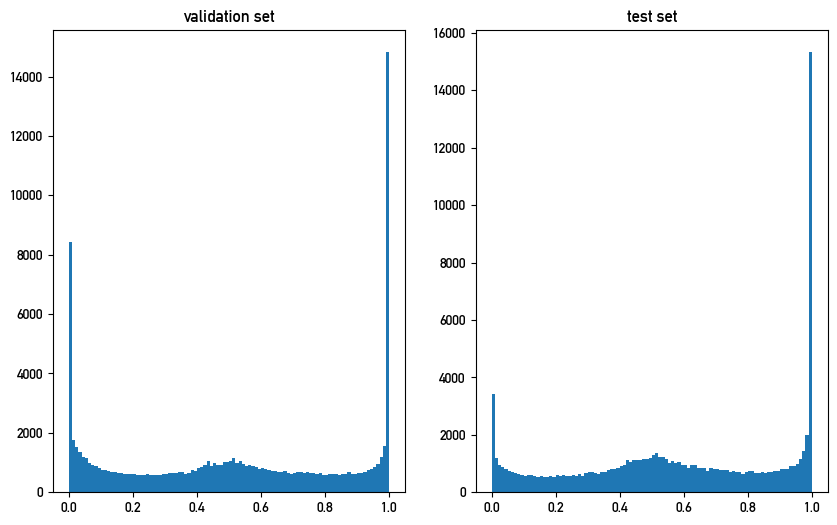

In [13]:
activations_validation = get_activations_vector(model, 
                                                dataset=validation_set, 
                                                batch_size=len(validation_set), 
                                                operators_to_pred=selection_operators, 
                                                device=device)
activations_test = get_activations_vector(model, 
                                          dataset=test_set, 
                                          batch_size=len(test_set), 
                                          operators_to_pred=selection_operators, 
                                          device=device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.hist(activations_validation, bins=100)
ax1.set_title("validation set")
ax2.hist(activations_test, bins=100)
ax2.set_title("test set")
plt.show()

In [14]:
dataset = "validation"

# get precision-recall and ROC values for different thresholds
pr_roc = get_pr_roc(model=model, 
                    dataset=validation_set, 
                    batch_size=len(validation_set), 
                    operators_to_pred=selection_operators, 
                    device=device, 
                    interval=(0,1), 
                    increment=0.1)

# save the PR and ROC values
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads, 
                            n_samples=n_training_samples, 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device_trained_on) + f"_{dataset}.csv"
pr_roc_path = os.path.join(vector_path, "model_outputs", "selection", "pr_roc", model_name)
pr_roc.to_csv(pr_roc_path, index=False)

In [15]:
dataset = "test"

# get precision-recall and ROC values for different thresholds
pr_roc = get_pr_roc(model=model, 
                    dataset=test_set, 
                    batch_size=len(test_set), 
                    operators_to_pred=selection_operators, 
                    device=device, 
                    interval=(0,1), 
                    increment=0.1)

# save the PR and ROC values
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads, 
                            n_samples=n_training_samples, 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device_trained_on) + f"_{dataset}.csv"
pr_roc_path = os.path.join(vector_path, "model_outputs", "selection", "pr_roc", model_name)
pr_roc.to_csv(pr_roc_path, index=False)

### Accuracy metrics

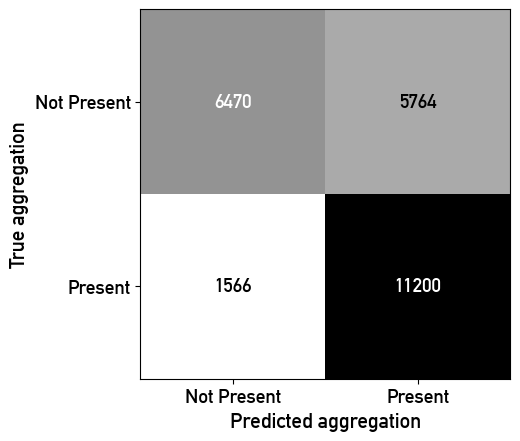

Accuracy: 0.707
Precision: 0.660
Recall: 0.877
F1 Score: 0.753


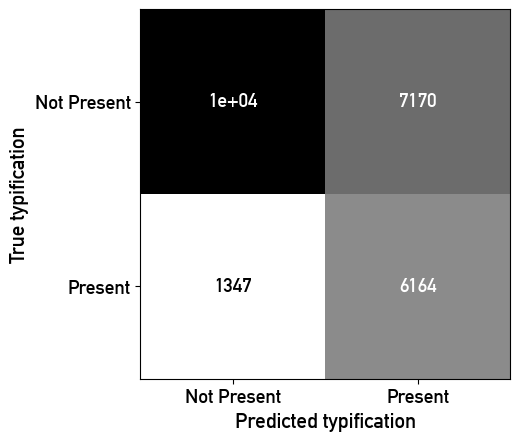

Accuracy: 0.659
Precision: 0.462
Recall: 0.821
F1 Score: 0.591


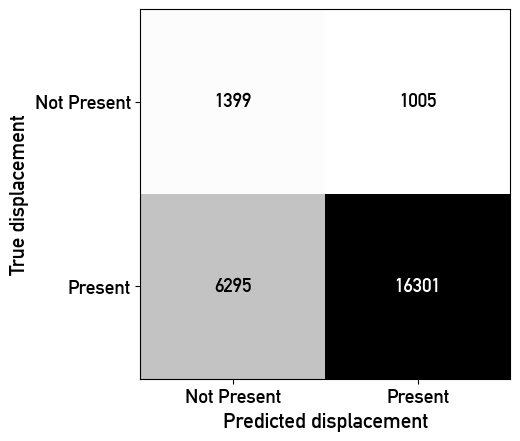

Accuracy: 0.708
Precision: 0.942
Recall: 0.721
F1 Score: 0.817


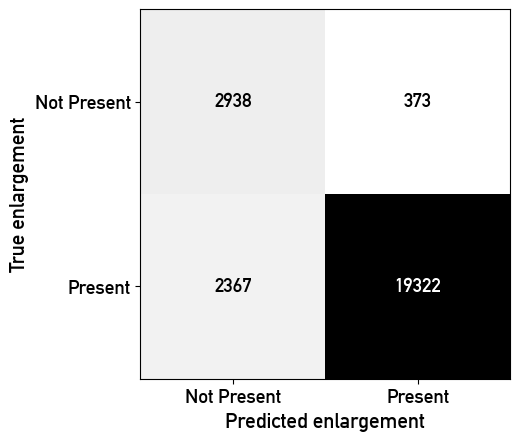

Accuracy: 0.890
Precision: 0.981
Recall: 0.891
F1 Score: 0.934


In [11]:
thresholds = vector_thresholds[f"{architecture.upper()} selection"]
thresholds_tensor = threshold_dic_to_tensor(thresholds)

# calculate accuracy metrics
metrics = get_metrics_vector(model=model, 
                             dataset=test_set,
                             batch_size=len(test_set),
                             operators_to_pred=selection_operators, 
                             threshold=thresholds_tensor, 
                             device=device)

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads,
                            n_samples=n_training_samples, 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device_trained_on) + ".csv"
metrics_path = os.path.join(vector_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with accuracy metrics
metrics_df = pd.DataFrame({"operator": metrics["operator"],
                           "accuracy": metrics["accuracy"], 
                           "precision": metrics["precision"],
                           "recall": metrics["recall"],
                           "f1-score": metrics["f1_score"]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# print the results
for i in range(len(selection_operators)):
    # display the confusion matrix
    visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])

    # print metrics
    print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
    print(f"Precision: {metrics['precision'][i]:.3f}")
    print(f"Recall: {metrics['recall'][i]:.3f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.3f}")

## ROC and PR curves for all models

In [6]:
# define paths
figure_path = "../../Figures/Results/pr_roc"
pr_roc_path_elimination = os.path.join(vector_path, "model_outputs", "elimination", "pr_roc")
pr_roc_path_selection = os.path.join(vector_path, "model_outputs", "selection", "pr_roc")

### HGNN

#### Validation set

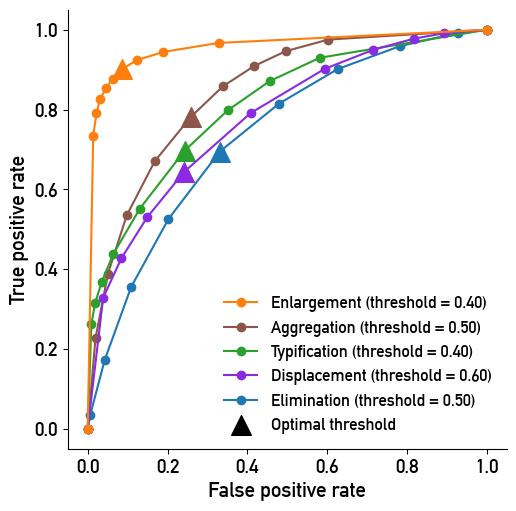

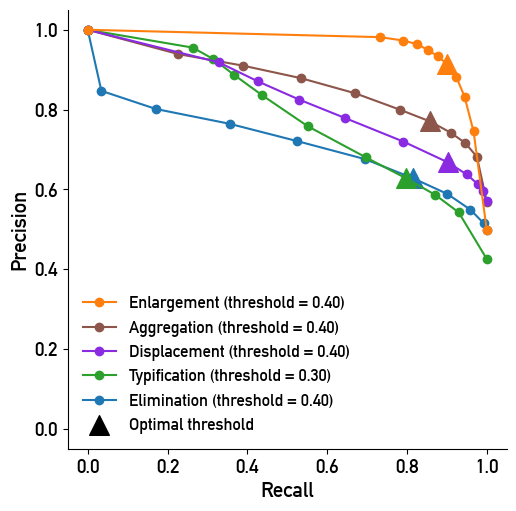

In [7]:
# define paths to PR and ROC CSV files
hgnn_validation_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                       "HGNN_eli_attachRoadsTrue_481665p_100000s_80ep_bs512_cuda_validation.csv"),
                          os.path.join(pr_roc_path_selection,
                                       "HGNN_sel_attachRoadsTrue_540548p_100000s_80ep_bs512_cuda_validation.csv")]

# output path
figure_path_hgnn_validation_roc = os.path.join(figure_path, "hgnn", "validation_roc.png")
figure_path_hgnn_validation_pr = os.path.join(figure_path, "hgnn", "validation_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "displacement", "elimination"]
pr_order = ["enlargement", "aggregation", "displacement", "typification", "elimination"]

# plot the curves
plot_roc_curve(hgnn_validation_pr_roc, 
               validation=True, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_hgnn_validation_roc)
plot_pr_curve(hgnn_validation_pr_roc, 
              validation=True, 
              legend_order=pr_order, 
              figsize=(5.7,5.7),
              save=True, 
              output_path=figure_path_hgnn_validation_pr)

#### Test set

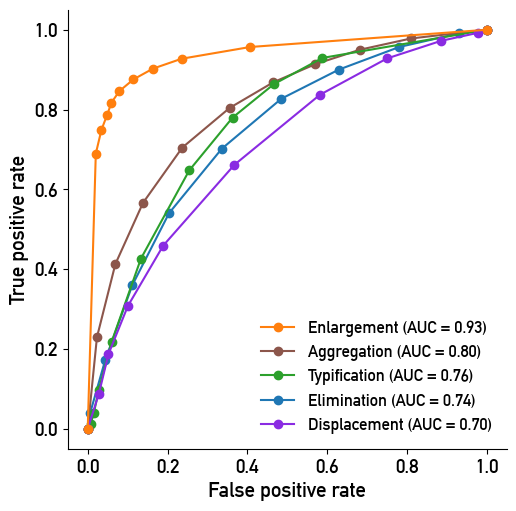

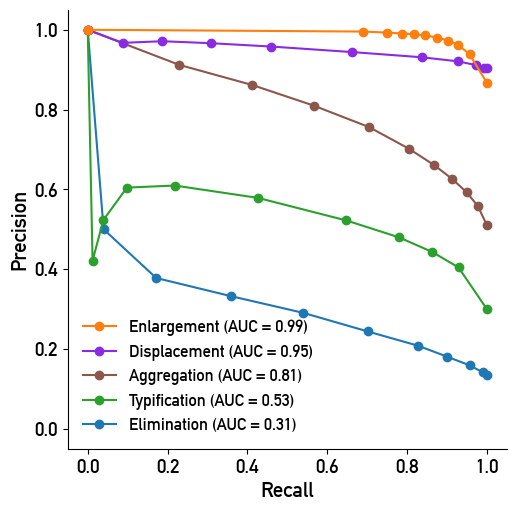

In [8]:
# define paths to PR and ROC CSV files
hgnn_test_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                 "HGNN_eli_attachRoadsTrue_481665p_100000s_80ep_bs512_cuda_test.csv"),
                    os.path.join(pr_roc_path_selection,
                                 "HGNN_sel_attachRoadsTrue_540548p_100000s_80ep_bs512_cuda_test.csv")]

# output path
figure_path_hgnn_test_roc = os.path.join(figure_path, "hgnn", "test_roc.png")
figure_path_hgnn_test_pr = os.path.join(figure_path, "hgnn", "test_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "elimination", "displacement"]
pr_order = ["enlargement", "displacement", "aggregation", "typification", "elimination"]

# plot the curves
plot_roc_curve(hgnn_test_pr_roc, 
               validation=False, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_hgnn_test_roc)
plot_pr_curve(hgnn_test_pr_roc, 
              validation=False, 
              legend_order=pr_order, 
              figsize=(5.7,5.7),
              save=True,
              output_path=figure_path_hgnn_test_pr)

### HGT

#### Validation set

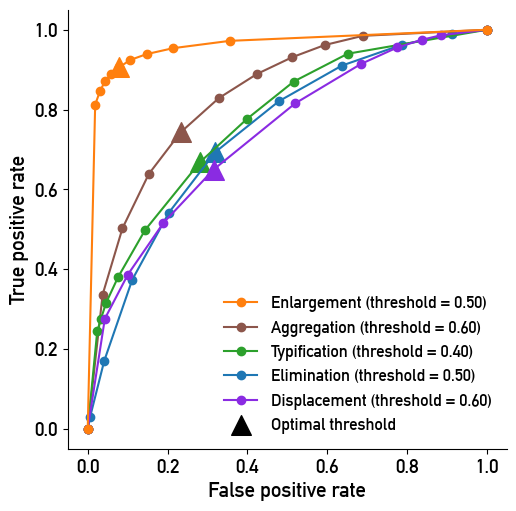

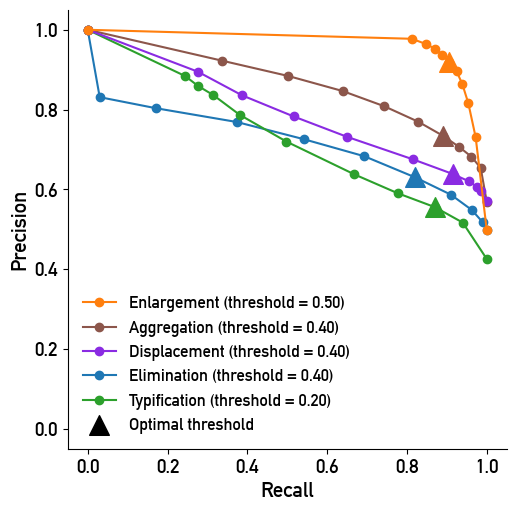

In [9]:
# define paths to PR and ROC CSV files
hgt_validation_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                      "HGT_eli_attachRoadsTrue_700466p_100000s_70ep_bs512_cuda_validation.csv"),
                         os.path.join(pr_roc_path_selection,
                                      "HGT_sel_attachRoadsTrue_750389p_100000s_130ep_bs512_cuda_validation.csv")]

# output path
figure_path_hgt_validation_roc = os.path.join(figure_path, "hgt", "validation_roc.png")
figure_path_hgt_validation_pr = os.path.join(figure_path, "hgt", "validation_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "elimination", "displacement"]
pr_order = ["enlargement", "aggregation", "displacement", "elimination", "typification"]

# plot the curves
plot_roc_curve(hgt_validation_pr_roc, 
               validation=True, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_hgt_validation_roc)
plot_pr_curve(hgt_validation_pr_roc, 
              validation=True, 
              legend_order=pr_order,
              figsize=(5.7,5.7),
              save=True, 
              output_path=figure_path_hgt_validation_pr)

#### Test set

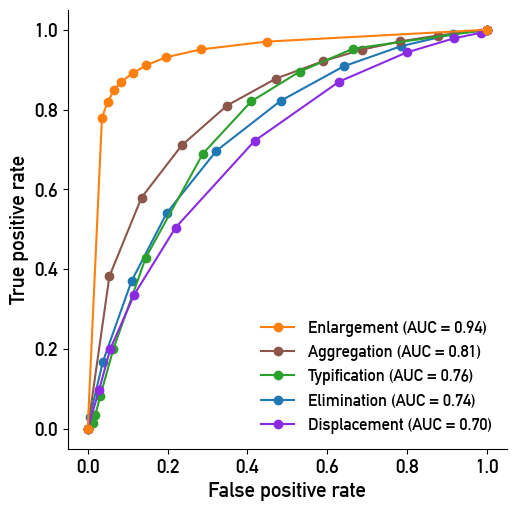

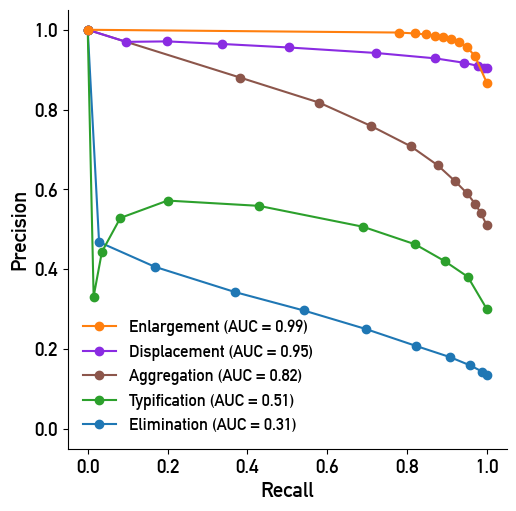

In [10]:
# define paths to PR and ROC CSV files
hgt_test_pr_roc = [os.path.join(pr_roc_path_elimination, 
                                "HGT_eli_attachRoadsTrue_700466p_100000s_70ep_bs512_cuda_test.csv"),
                   os.path.join(pr_roc_path_selection,
                                "HGT_sel_attachRoadsTrue_750389p_100000s_130ep_bs512_cuda_test.csv")]

# output path
figure_path_hgt_test_roc = os.path.join(figure_path, "hgt", "test_roc.png")
figure_path_hgt_test_pr = os.path.join(figure_path, "hgt", "test_pr.png")

# legend order
roc_order = ["enlargement", "aggregation", "typification", "elimination", "displacement"]
pr_order = ["enlargement", "displacement", "aggregation", "typification", "elimination"]

# plot the curves
plot_roc_curve(hgt_test_pr_roc, 
               validation=False, 
               legend_order=roc_order, 
               figsize=(5.7,5.7),
               save=True, 
               output_path=figure_path_hgt_test_roc)
plot_pr_curve(hgt_test_pr_roc, 
              validation=False, 
              legend_order=pr_order, 
              figsize=(5.7,5.7),
              save=True, 
              output_path=figure_path_hgt_test_pr)